## Importing necessary libraries and checking if the GPU is recognized

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
cifar10 = keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## changing the encoding of the output to one hot encoding

In [5]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## Resnet 20 architecture

In [7]:
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])  # Adding the shortcut connection
    x = Activation('relu')(x)
    return x

def build_resnet_20(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, kernel_size=3, padding='same')(inputs)

    for _ in range(3):  # Three groups of residual blocks
        for _ in range(3):  # Each group contains three blocks
            x = residual_block(x, 16)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


## Resnet 20 Without Hyperparameter tuning

In [ ]:
model = build_resnet_20()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath="/content/drive/MyDrive/ResNet20/model_epoch_{epoch:02d}.keras",  # Save file with epoch number
    save_freq='epoch'
  )

# Train the model with the callback
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=70,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback]
)


NameError: name 'model' is not defined

In [ ]:
# prompt: use pickle to save the model

import pickle

# Save the model to a file
with open('resnet_model.pkl', 'wb') as file:
    pickle.dump(model, file)

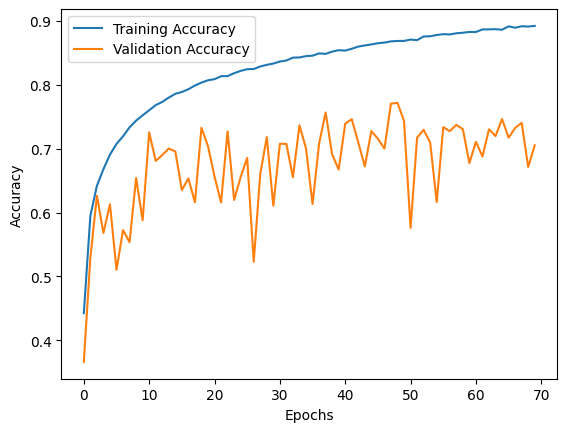

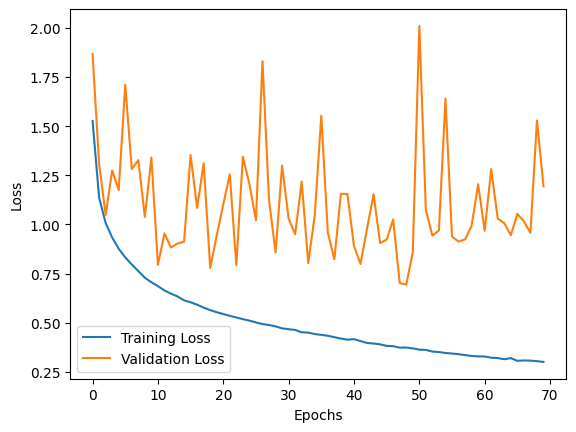

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Resnet 20 with Hyperparameter tuning, Image Augmentation, Checkpointing, Early Stopping (based on validation loss) and Learning Rate Reduction (based on validation loss)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath="/content/drive/MyDrive/ResNet20/model_epoch_best_{epoch:02d}.keras",  # Save file with epoch number
    save_best_only=True,
  )

model_new = build_resnet_20()
model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the callback
history = model_new.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=70,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback, early_stopping, lr_reduction]
)


Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 35ms/step - accuracy: 0.3431 - loss: 1.7980 - val_accuracy: 0.3897 - val_loss: 1.9529 - learning_rate: 0.0010
Epoch 2/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.5401 - loss: 1.2736 - val_accuracy: 0.4143 - val_loss: 1.9925 - learning_rate: 0.0010
Epoch 3/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - accuracy: 0.5923 - loss: 1.1361 - val_accuracy: 0.5097 - val_loss: 1.5893 - learning_rate: 0.0010
Epoch 4/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6259 - loss: 1.0492 - val_accuracy: 0.5877 - val_loss: 1.2145 - learning_rate: 0.0010
Epoch 5/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - accuracy: 0.6366 - loss: 1.0043 - val_accuracy: 0.5916 - val_loss: 1.1888 - learning_rate: 0.0010
Epoch 6/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - accuracy: 0.6499 - loss: 0.9664 - val_accuracy: 0.5105 - val_loss: 1.5852 - learning_rate: 0.0010
Epoch 7/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - accuracy: 0.6716 

In [ ]:
# prompt: use pickle to save the model

import pickle

# Save the model to a file
with open('resnet_model.pkl', 'wb') as file:
    pickle.dump(model, file)

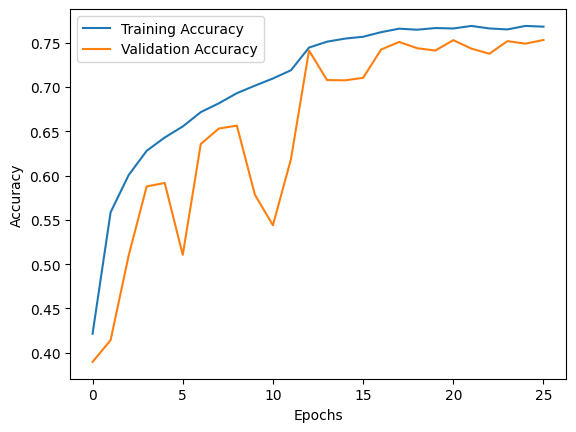

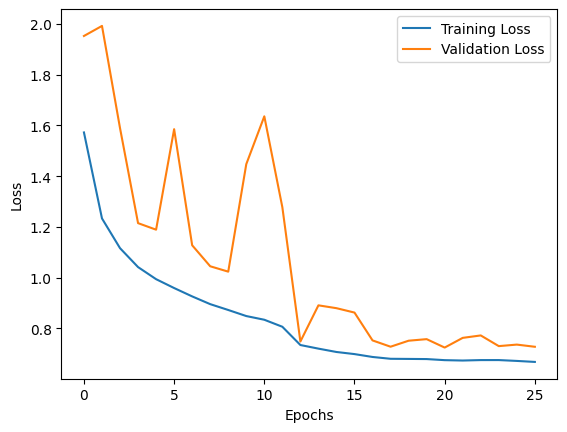

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Resnet V2 Model with optimization

In [14]:
model_resnet50 = keras.applications.ResNet50V2(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=10
)

model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath="/content/drive/MyDrive/ResNet20/model_epoch_resnet_best_{epoch:02d}.keras",  # Save file with epoch number
    save_best_only=True,
    save_freq=5
  )

history = model_resnet50.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=70,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback, early_stopping, lr_reduction]
)

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   9/1563 ━━━━━━━━━━━━━━━━━━━━ 1:06 43ms/step - accuracy: 0.1487 - loss: 2.8206

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:199: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 53ms/step - accuracy: 0.2967 - loss: 2.0559 - val_accuracy: 0.2983 - val_loss: 5.6703 - learning_rate: 0.0010
Epoch 2/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.3799 - loss: 1.7894 - val_accuracy: 0.2375 - val_loss: 2.1334 - learning_rate: 0.0010
Epoch 3/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.3812 - loss: 1.7498 - val_accuracy: 0.4653 - val_loss: 1.5626 - learning_rate: 0.0010
Epoch 4/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.4282 - loss: 1.6216 - val_accuracy: 0.4409 - val_loss: 1.8394 - learning_rate: 0.0010
Epoch 5/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.4563 - loss: 1.5495 - val_accuracy: 0.4643 - val_loss: 1.5859 - learning_rate: 0.0010
Epoch 6/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.5073 - loss: 1.3996 - val_accuracy: 0.4628 - val_loss: 1.5266 - learning_rate: 0.0010
Epoch 7/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.5376

In [12]:
model_resnet50.save('/content/drive/MyDrive/ResNet20/model_resnet50.keras')

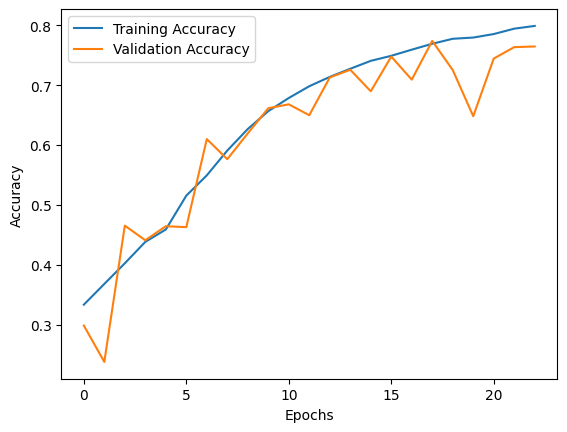

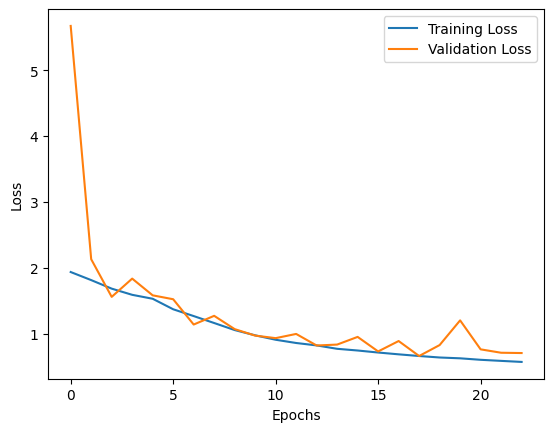

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Key Observations

* The validation accuracy could not get past 75% with any amount of hypertuning in resnet 20 architecture
* with resnet 50 v2, the model did perform better with upto an accuracy of 82 percent (the above image is not based on that model)
* from online reports the highest accuracy anybody has ever got with randomly initialized weights on any architecture is 85%. with pretrained weights the model performed upto 97%

## Phase 2: Converting the model to ONNX format for inference on tensorRT

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load the Keras model
model = load_model('/content/drive/MyDrive/ResNet20/model_resnet50.keras')

# Define the directory where the TensorFlow SavedModel will be exported
export_path = '/content/drive/MyDrive/ResNet20/saved_model'

# Save the model using the TensorFlow SavedModel format
tf.saved_model.save(model, export_path)

print(f"Model successfully saved as a TensorFlow SavedModel at {export_path}")


Model successfully saved as a TensorFlow SavedModel at /content/drive/MyDrive/ResNet20/saved_model


### Executing the following command might instruct you to restart the runtime but it is not necessary and I'd advise you against it

In [5]:
!pip install -U tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [6]:
!python -m tf2onnx.convert --saved-model "/content/drive/MyDrive/ResNet20/saved_model" --output "/content/drive/MyDrive/ResNet20/saved_model.onnx" --opset 16

2025-01-24 05:38:02.037747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 05:38:02.076627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 05:38:02.088292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 05:38:04.312562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-01-24 05:38:06,524 - WARNING - ***IMPO

## Phase 3: Running inference on the TensorRT runtime

### Converting ONNX to .trt (tensorrt) model

In [13]:
!nvcc --version
!cat /etc/os-release

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [31]:
!wget https://developer.nvidia.com/downloads/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz -O tensorrt.tar.gz

--2025-01-24 06:07:54--  https://developer.nvidia.com/downloads/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz
Resolving developer.nvidia.com (developer.nvidia.com)... 23.60.173.16, 23.60.173.59
Connecting to developer.nvidia.com (developer.nvidia.com)|23.60.173.16|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://developer.download.nvidia.com/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz [following]
--2025-01-24 06:07:55--  https://developer.download.nvidia.com/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.60.173.59, 23.60.173.16
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.60.173.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2348693005 (2.2G) 

In [35]:
!/content/TensorRT-10.0.0.6/bin/trtexec --onnx=/content/drive/MyDrive/ResNet20/saved_model.onnx --saveEngine=/content/drive/MyDrive/ResNet20/saved_model.trt

&&&& RUNNING TensorRT.trtexec [TensorRT v100000] # /content/TensorRT-10.0.0.6/bin/trtexec --onnx=/content/drive/MyDrive/ResNet20/saved_model.onnx --saveEngine=/content/drive/MyDrive/ResNet20/saved_model.trt
[01/24/2025-06:17:34] [I] === Model Options ===
[01/24/2025-06:17:34] [I] Format: ONNX
[01/24/2025-06:17:34] [I] Model: /content/drive/MyDrive/ResNet20/saved_model.onnx
[01/24/2025-06:17:34] [I] Output:
[01/24/2025-06:17:34] [I] === Build Options ===
[01/24/2025-06:17:34] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[01/24/2025-06:17:34] [I] avgTiming: 8
[01/24/2025-06:17:34] [I] Precision: FP32
[01/24/2025-06:17:34] [I] LayerPrecisions: 
[01/24/2025-06:17:34] [I] Layer Device Types: 
[01/24/2025-06:17:34] [I] Calibration: 
[01/24/2025-06:17:34] [I] Refit: Disabled
[01/24/2025-06:17:34] [I] Strip weights: Disabled
[01/24/2025-06:17:34] [I] Version Compatible: Disabled
[01/24/2025-06:17:34] [I] ONNX Pl

### Comparing the inference speeds of both trt and tensorflow model

In [42]:
!pip install tensorrt pycuda

In [43]:
import tensorflow as tf
import tensorrt as trt
import numpy as np
import time
import pycuda.driver as cuda
import pycuda.autoinit
from tensorflow.keras.datasets import cifar10

# Configuration
BATCH_SIZE = 1
INPUT_SHAPE = (32, 32, 3)  # CIFAR-10 input shape
NUM_ITERATIONS = 1000
NUM_WARMUP = 50

# Load and preprocess CIFAR-10 data
(_, _), (x_test, _) = cifar10.load_data()
x_test = x_test.astype(np.float32) / 255.0  # Normalize to [0, 1]
x_test = x_test[:NUM_ITERATIONS]  # Use subset for benchmarking

# Helper function for TensorRT
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

def allocate_buffers(engine):
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()

    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * BATCH_SIZE
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        bindings.append(int(device_mem))

        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))

    return inputs, outputs, bindings, stream

def do_inference(context, bindings, inputs, outputs, stream, batch_size=BATCH_SIZE):
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    context.execute_async(batch_size=batch_size, bindings=bindings, stream_handle=stream.handle)
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    stream.synchronize()
    return [out.host for out in outputs]

def benchmark_tensorrt(model_path):
    # Load TensorRT engine
    with open(model_path, 'rb') as f, trt.Runtime(trt.Logger(trt.Logger.WARNING)) as runtime:
        engine = runtime.deserialize_cuda_engine(f.read())

    context = engine.create_execution_context()
    inputs, outputs, bindings, stream = allocate_buffers(engine)

    # Warmup
    for i in range(NUM_WARMUP):
        img = x_test[i % len(x_test)].ravel()
        np.copyto(inputs[0].host, img)
        do_inference(context, bindings, inputs, outputs, stream)

    # Benchmark
    times = []
    for i in range(NUM_ITERATIONS):
        img = x_test[i % len(x_test)].ravel()
        np.copyto(inputs[0].host, img)

        start_time = time.time()
        do_inference(context, bindings, inputs, outputs, stream)
        times.append(time.time() - start_time)

    # Calculate metrics
    avg_latency = np.mean(times) * 1000  # in milliseconds
    throughput = 1000 / avg_latency * BATCH_SIZE  # requests per second
    return avg_latency, throughput

def benchmark_tensorflow(model_path):
    # Load TensorFlow model
    model = tf.saved_model.load(model_path)
    infer = model.signatures['serving_default']

    # Warmup
    for i in range(NUM_WARMUP):
        img = x_test[i % len(x_test)][np.newaxis, ...]  # Add batch dimension
        infer(tf.constant(img))

    # Benchmark
    times = []
    for i in range(NUM_ITERATIONS):
        img = x_test[i % len(x_test)][np.newaxis, ...]

        start_time = time.time()
        infer(tf.constant(img))
        times.append(time.time() - start_time)

    # Calculate metrics
    avg_latency = np.mean(times) * 1000  # in milliseconds
    throughput = 1000 / avg_latency * BATCH_SIZE  # requests per second
    return avg_latency, throughput

if __name__ == '__main__':
    # TensorRT Benchmark
    print("Benchmarking TensorRT model...")
    trt_latency, trt_throughput = benchmark_tensorrt('/content/drive/MyDrive/ResNet20/saved_model.trt')

    # TensorFlow Benchmark
    print("\nBenchmarking TensorFlow model...")
    tf_latency, tf_throughput = benchmark_tensorflow('/content/drive/MyDrive/ResNet20/saved_model')

    # Print results
    print("\nResults:")
    print(f"TensorRT Average Latency: {trt_latency:.2f}ms")
    print(f"TensorRT Throughput: {trt_throughput:.2f} requests/sec")
    print(f"TensorFlow Average Latency: {tf_latency:.2f}ms")
    print(f"TensorFlow Throughput: {tf_throughput:.2f} requests/sec")

ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

In [41]:
!mv /content/tensorrt.tar.gz /content/drive/MyDrive/ResNet20